In [3]:
from __future__ import division
import bs4
import urllib2
import pandas as pd
import scrabble_points_name

## Getting the Data

Like last time, I have to scrape this data. Luckily, Fox Sports posts a [list](http://www.foxsports.com/nfl/players) of every 2016 NFL player online and it's pretty easy to access.

This is what the players pages look like:
![](images/fox_sports_images/raw.png?raw=true)

Clicking on any one of the 167 pages illustrates base URL we need to scrape all the pages, `http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=`. We'll just put the numbers 1 to 167 into the url after `page=` when we want that particular page.

To get the player names and teams out of the page we need to dive into the source code. Inspecting one of the names returns:
![](images/fox_sports_images/player_html.png?raw=true)

All the data we want is in a `table` with `class=wisbb_standardTable tablesorter`. Every row in the table is a `tr` tag, and the player and team names are in separate `td` tags with their own `classes`. We can use BeautifulSoup to extract them and store them in a list.

In [175]:
fox_nfl_url = 'http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page='

players_list = []
full_teams_list = []

for i in range(1, 168):
    link = fox_nfl_url + str(i)
    print link
    
    response = urllib2.urlopen(link)
    html = response.read()
    soup = bs4.BeautifulSoup(html)
    table = soup.find('table', {'class' : 'wisbb_standardTable tablesorter'})
    tr = table.find_all('tr')
    
    # 26 elements in tr. First one is the headers so we can ignore it.
    names_list = []
    teams_list = []
    
    for each in tr[1:]:
        try:
            name = str(each.find('td', {'class': 'wisbb_text wisbb_fixedColumn'}).find('span').text)            
            team = str(each.find('td', {'class': 'wisbb_priorityColumn'}).find('a').text)
            
            if name and team:
                names_list.append(name)
                teams_list.append(team)
                #print name, team
        except:
            pass
    
    players_list += names_list
    full_teams_list += teams_list

http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=1
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=2
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=3
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=4
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=5
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=6
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=7
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=8
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=9
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=10
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=11
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=12
http://www.foxsports.com/nfl/players?teamId=0&season=2016&position=0&page=13
http://w

Let's see what the data look like

In [176]:
print players_list[:5]
print full_teams_list[:5]

['Aaitui, Isaako', 'Abbrederis, Jared', 'Abdesmad, Mehdi', 'Abdul-Quddus, Isa', 'Abdullah, Ameer']
['TEN', 'GB', 'TEN', 'MIA', 'DET']


Looks good. Let's split them into first and last names so we can score by first or last name only if we want. I use the `if else` statements to avoid losing the full names of players such as Brian de la Puente (with multiple spaces).

In [177]:
first_names = [x.split(',')[1].strip() for x in players_list]
last_names = [x.split(',')[0].strip() for x in players_list]
print len(first_names), len(last_names)

4163 4163


In [178]:
# Fix the problem with multi-space names (Brian de la Puente, for example)
fixed_first_names = []
fixed_last_names = []

for each in first_names:
    if len(each.split()) > 1:
        joined_first_name = ''.join(each.split())
        fixed_first_names.append(joined_first_name)
    else:
        fixed_first_names.append(each)

for each in last_names:
    if len(each.split()) > 1:
        joined_last_name = ''.join(each.split())
        fixed_last_names.append(joined_last_name)
    else:
        fixed_last_names.append(each)

In [179]:
print len(fixed_first_names), len(fixed_last_names)

4163 4163


Now I'll zip the players and teams into a tuple, and store them in a list

In [180]:
names_teams_tuples = zip(fixed_first_names, fixed_last_names, full_teams_list)
names_teams_tuples[:5]

[('Isaako', 'Aaitui', 'TEN'),
 ('Jared', 'Abbrederis', 'GB'),
 ('Mehdi', 'Abdesmad', 'TEN'),
 ('Isa', 'Abdul-Quddus', 'MIA'),
 ('Ameer', 'Abdullah', 'DET')]

## Scrabble Scoring the Players

First I define a function that takes a string as input and returns the scrabble point value of the string.

In [2]:
import string

letter_points_dictionary = {
    
    'a': 1,
    'e': 1,
    'i': 1,
    'o': 1,
    'u': 1,
    'l': 1,
    'n': 1,
    's': 1,
    't': 1,
    'r': 1,
    'd': 2,
    'g': 2,
    'b': 3,
    'c': 3,
    'm': 3,
    'p': 3,
    'f': 4,
    'h': 4,
    'v': 4,
    'w': 4,
    'y': 4,
    'k': 5,
    'j': 8,
    'x': 8,
    'q': 10,
    'z': 10

}

def scrabble_score(name):
    """
    Returns scrabble score of the name based on the letters
    """
    letters_only = str(name).translate(None, string.punctuation)
    name_letters = list(letters_only.lower().strip())
    scores = [letter_points_dictionary[letr] for letr in name_letters]
    return sum(scores)


Now I can score the players names and put them into a pandas dataframe and sort it by score.

In [258]:
scrabble_nfl_list = []

for name in names_teams_tuples:
    #print name
    first_name = name[0]
    last_name = name[1]
    team = name[2]
    
    first_points = scrabble_points_name.scrabble_score(first_name)
    last_points = scrabble_points_name.scrabble_score(last_name)
    tup = first_name, last_name, team, first_points, last_points, first_points + last_points
    #print tup
    scrabble_nfl_list.append(tup)


In [259]:
nfl_scores_df = pd.DataFrame(scrabble_nfl_list, columns = ['first_name', 'last_name', 'team', 'first_name_score', 'last_name_score', 'combined_score'])
nfl_scores_df.sort('combined_score', ascending=False, inplace = True)
nfl_scores_df.head()

/Users/nickbecker/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,first_name,last_name,team,first_name_score,last_name_score,combined_score
3167,Jacquizz,Rodgers,CHI,44,9,53
1998,Kyle,Juszczyk,BAL,11,42,53
3300,Al-Hajj,Shabazz,PIT,23,30,53
4158,Tyrequek,Zimmerman,ARZ,24,24,48
3960,Fozzy,Whittaker,CAR,29,19,48


For plotting purposes I'll combine the first and last name into the full name.

In [262]:
nfl_scores_df['full_name'] = (nfl_scores_df['first_name'].
                                     str.cat(nfl_scores_df['last_name'], sep = ' ').
                                     str.cat(nfl_scores_df['team'], sep = ', ')
                                     )

In [3]:
nfl_scores_df.to_csv('nfl_scrabble_score.csv', index = False)

NameError: name 'nfl_scores_df' is not defined

# Plotting the Best Individual Player Scores

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Load the player scores from the file
nfl_player_scores_df = pd.read_csv('nfl_scrabble_score.csv')
nfl_player_scores_df.head()

,first_name,last_name,team,first_name_score,last_name_score,combined_score,full_name
0,Jacquizz,Rodgers,CHI,44,9,53,"Jacquizz Rodgers, CHI"
1,Kyle,Juszczyk,BAL,11,42,53,"Kyle Juszczyk, BAL"
2,Al-Hajj,Shabazz,PIT,23,30,53,"Al-Hajj Shabazz, PIT"
3,Tyrequek,Zimmerman,ARZ,24,24,48,"Tyrequek Zimmerman, ARZ"
4,Fozzy,Whittaker,CAR,29,19,48,"Fozzy Whittaker, CAR"


Let's plot just the top 25 players using `matplotlib` and `seaborn` for the theme.

In [6]:
top_players = nfl_player_scores_df.head(25)
top_players.head()

,first_name,last_name,team,first_name_score,last_name_score,combined_score,full_name
0,Jacquizz,Rodgers,CHI,44,9,53,"Jacquizz Rodgers, CHI"
1,Kyle,Juszczyk,BAL,11,42,53,"Kyle Juszczyk, BAL"
2,Al-Hajj,Shabazz,PIT,23,30,53,"Al-Hajj Shabazz, PIT"
3,Tyrequek,Zimmerman,ARZ,24,24,48,"Tyrequek Zimmerman, ARZ"
4,Fozzy,Whittaker,CAR,29,19,48,"Fozzy Whittaker, CAR"


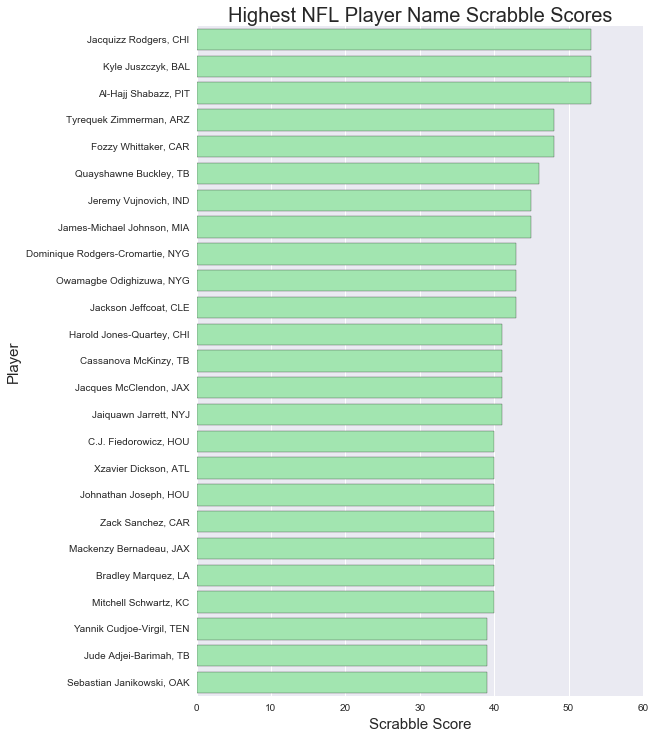

In [7]:
f = plt.figure(figsize = (8, 12))
ax = plt.axes()
sns.set(font_scale = 1.25)
sns.set_color_codes('pastel')
sns.barplot(x = 'combined_score', y = 'full_name', data = top_players, color = 'g')
plt.xlabel('Scrabble Score', size = 15)
plt.ylabel('Player', size = 15)
ax.xaxis.set_label_position('bottom')
sns.despine(left = True, bottom = True)
plt.title('Highest NFL Player Name Scrabble Scores', size = 20)

These are some high scores. _**Strong**_ performances by Jacquizz Rodgers, Kyle Juszcyzk, and Al-Hajj Shabazz due to the two `z`'s in their names.

Let's rank the teams by the total score of all their players.

# Plotting the Scores for every NFL Team

To get the total score for each team, I'll group `nfl_player_scores_df` by `team` and calculate the group `combined_score` sums. Then I'll plot them in the same way as the individual scores.

In [8]:
team_df =  (nfl_player_scores_df.
       groupby(by = ['team'])['combined_score'].
       sum().
       reset_index().
       sort_values('combined_score', ascending = False)
       )

team_df.to_csv('nfl_team_scrabble_score.csv', index = False)

In [9]:
# Load the team scores from the file
nfl_team_scores_df = pd.read_csv('nfl_team_scrabble_score.csv')

In [11]:
nfl_team_scores_df.head()

,team,combined_score
0,IND,3337
1,PIT,3299
2,NYG,3216
3,DAL,3216
4,ATL,3209


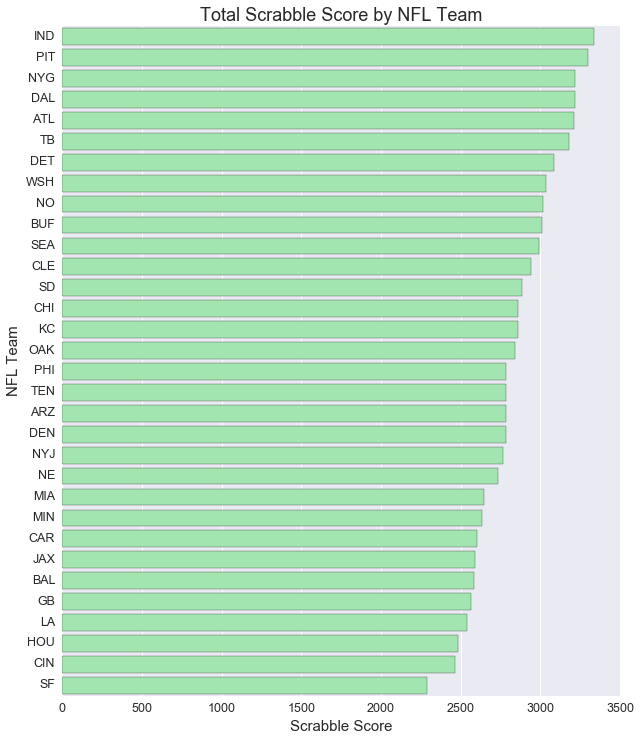

In [12]:
f = plt.figure(figsize = (10, 12))
ax = plt.axes()
sns.set(font_scale = 1.5)
sns.set_color_codes('pastel')
sns.barplot(x = 'combined_score', y = 'team', data = nfl_team_scores_df, color = 'g')
ax.xaxis.set_label_position('bottom')
sns.despine(left = True, bottom = True)
plt.xlabel('Scrabble Score', size = 15)
plt.ylabel('NFL Team', size = 15)
plt.title('Total Scrabble Score by NFL Team')

Not a bad showing by the Washington Redskins (8th), except for the fact that the Dallas Cowboys and New York Giants came in 3rd and 4th, respectively. Still, I think most Redskins fans would be happy if they made the Divisional Round of the NFL Playoffs (quarterfinals).

# Plot the best individual player per team

In [255]:
max_per_team_idx = nfl_player_scores_df.groupby(by = ['team'])['combined_score'].transform(max) == nfl_player_scores_df['combined_score']
highest_score_per_team = nfl_player_scores_df[max_per_team_idx].sort_values(['combined_score', 'team'], ascending = False)
highest_score_per_team.head()

,first_name,last_name,team,first_name_score,last_name_score,combined_score,full_name
2,Al-Hajj,Shabazz,PIT,23,30,53,"Al-Hajj Shabazz, PIT"
0,Jacquizz,Rodgers,CHI,44,9,53,"Jacquizz Rodgers, CHI"
1,Kyle,Juszczyk,BAL,11,42,53,"Kyle Juszczyk, BAL"
4,Fozzy,Whittaker,CAR,29,19,48,"Fozzy Whittaker, CAR"
3,Tyrequek,Zimmerman,ARZ,24,24,48,"Tyrequek Zimmerman, ARZ"


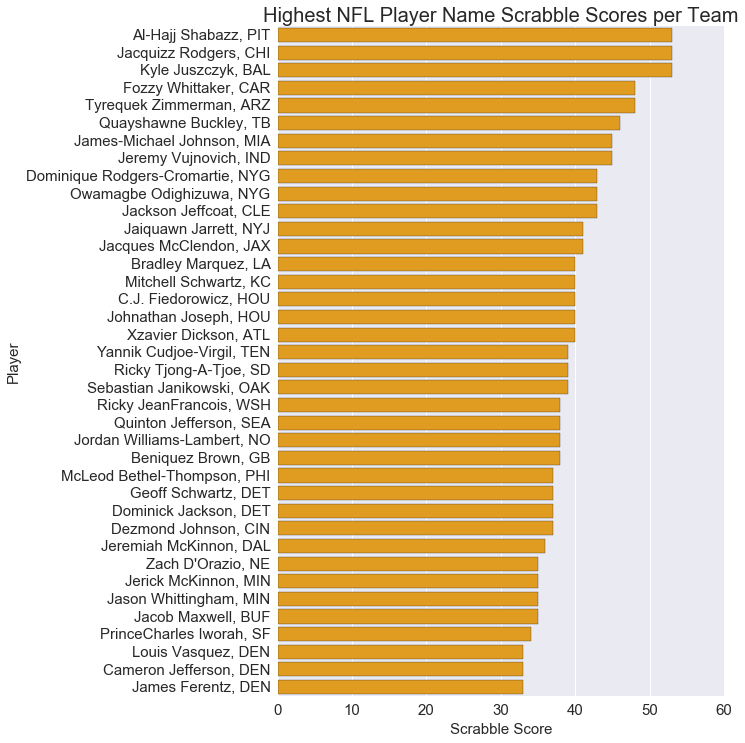

In [256]:
#sns.set(style='darkgrid')
f = plt.figure(figsize = (8, 12))
ax = plt.axes()
sns.set(font_scale = 1.25)
sns.set_color_codes('pastel')
sns.barplot(x = 'combined_score', y = 'full_name', data = highest_score_per_team, color = 'orange')
#ax.set(xlabel = 'Scrabble Score', ylabel = 'Player Name')
plt.xlabel('Scrabble Score', size = 15)
plt.ylabel('Player', size = 15)
ax.xaxis.set_label_position('bottom')
sns.despine(left = True, bottom = True)
plt.title('Highest NFL Player Name Scrabble Scores per Team', size = 20)